# Прогноз оттока клиентов для оператора связи

На основе информации о клиентах оператора связи, построить модель способную прогнозировать отток.

### Описание услуг
Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. _digital subscriber line_, «цифровая абонентская линия») или оптоволоконный кабель (_Fiber optic_).

Также доступны такие услуги:

* Интернет-безопасность: антивирус (_DeviceProtection)_ и блокировка небезопасных сайтов (_OnlineSecurity_)
* Выделенная линия технической поддержки (_TechSupport_)
* Облачное хранилище файлов для резервного копирования данных (_OnlineBackup_)
* Стриминговое телевидение (_StreamingTV_) и каталог фильмов (_StreamingMovies_).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


### Описание данных

Данные состоят из файлов, полученных из разных источников:

* _contract.csv_ — информация о договоре
* _personal.csv_ — персональные данные клиента
* _internet.csv_ — информация об интернет-услугах
* _phone.csv_ — информация об услугах телефонии.

Во всех файлах столбец __customerID__ содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Расшифровка столбцов
* customerID - идентификационный номер клиента
* BeginDate - дата начала пользования услугами
* EndDate - дата окончания пользования услугами
* Type - тип оплаты: ежемесячный, годовой и тд
* PaperlessBilling – безналичный расчет
* PaymentMethod – способ оплаты
* MonthlyCharges – ежемесячные траты на услуги
* TotalCharges – всего потрачено денег на услуги
* Dependents – наличие иждивенцев
* Senior Citizen – наличие пенсионного статуса по возрасту
* Partner – наличие супруга(и)
* MultipleLines – наличие возможности ведения параллельных линий во время звонка


### План работы

1. Исследование данных.
2. Подготовка данных.
3. Подбор моделей и гиперпараметров.
4. Тестирование.

## Импорт данных и библиотек

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix

from catboost import Pool, CatBoostClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)


#настройки
import warnings
warnings.filterwarnings("ignore")


In [69]:
contract = pd.read_csv("./data/contract.csv", index_col = "customerID")
internet = pd.read_csv("./data/internet.csv", index_col = "customerID")
personal = pd.read_csv("./data/personal.csv", index_col = "customerID")
phone = pd.read_csv("./data/phone.csv", index_col = "customerID")
data = {"contract":contract, "internet":internet,"personal":personal,"phone":phone}

In [70]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [71]:
for key,df in data.items():
    print(key)
    get_data_info(df)
    print("-"*50)

contract


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
2959-FENLU,2019-05-01,No,Month-to-month,Yes,Credit card (automatic),85.30,781.4
8050-XGRVL,2014-12-01,No,One year,No,Credit card (automatic),54.75,3425.35
9402-CXWPL,2014-04-01,No,One year,No,Electronic check,98.90,6838.6
3720-DBRWL,2015-11-01,No,Two year,Yes,Credit card (automatic),83.85,4307.1
1576-PFZIW,2014-04-01,No,Two year,No,Credit card (automatic),105.35,7511.9


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


None

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,77,5,3,2,4,NaN,6531
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


--------------------------------------------------
internet


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7399-QHBJS,DSL,Yes,Yes,No,Yes,No,No
1897-OKVMW,DSL,Yes,Yes,Yes,Yes,Yes,Yes
1866-DIOQZ,DSL,Yes,Yes,Yes,Yes,Yes,Yes
1866-NXPSP,DSL,Yes,Yes,Yes,Yes,No,Yes
0401-WDBXM,Fiber optic,Yes,No,Yes,No,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


--------------------------------------------------
personal


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
5149-CUZUJ,Male,0,Yes,Yes
5605-XNWEN,Male,1,Yes,No
8404-VLQFB,Female,0,Yes,Yes
0504-HHAPI,Female,1,No,No
1121-QSIVB,Female,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


--------------------------------------------------
phone


,MultipleLines
customerID,
3932-IJWDZ,Yes
9850-OWRHQ,Yes
0011-IGKFF,No
4349-GFQHK,Yes
5846-QFDFI,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

,MultipleLines
count,6361
unique,2
top,No
freq,3390


--------------------------------------------------


**Вывод**

Пропусков нет. Следует рассмотреть столбец TotalCharges и привести его к числовому формату. У признака SeniorCitizen стоит изменить тип данных, т.к. он является категориальным признаком. Необходимо добавить признак об использовании телефонии или интернета. А также необходимо создать бинарный целевой признак.

Начнём с TotalCharges и найдем пользователей с пустыми полями.

In [72]:
contract[contract["TotalCharges"].str.isspace()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


Заменим пропуски в столбце на месячный платёж и преобразуем формат данных в столбце.

In [73]:
contract["TotalCharges"].mask(contract["TotalCharges"].str.isspace(),contract["MonthlyCharges"],inplace=True)
contract["TotalCharges"] = pd.to_numeric(contract["TotalCharges"])
#df[‘column_name’].mask( df[‘column_name’] == ‘some_value’, value , inplace=True )

In [74]:
contract[contract["TotalCharges"] != ""].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(5)
memory usage: 440.2+ KB


Добавим бинарный признак для интернета и телефонии.

In [75]:
data['internet']['internet'] = 'Yes'
data['phone']['phone'] = 'Yes'

Объеденим всё в один датафрейм и удалим номер, т.к. бесполезный признак.

In [76]:
df = contract.join([data[i] for i in data.keys() if i != "contract"]).reset_index()

Заменим тип данных в SeniorCitizen, т.к. это категориальный признак.

In [77]:
df.loc[df["SeniorCitizen"] == 0, "SeniorCitizen"] = "No"
df.loc[df["SeniorCitizen"] == 1, "SeniorCitizen"] = "Yes"

Заполним пропуски "No", потому что они обусловлены  объедением наборов данных по разным услугам.

In [78]:
df = df.fillna("No")

In [79]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        
 13  StreamingTV       7043 non-null   object        
 14  StreamingMovies   7043 n

Найдём всех клиентов, которые ушли и остались. А также создадим целевой признак.

In [80]:
clientsLeft = df.loc[df['EndDate'] != 'No']
clientsStay = df.loc[df['EndDate'] == 'No']
df.loc[df['EndDate'] != 'No','exit'] = 1
df.loc[df['EndDate'] == 'No', 'exit'] = 0
df['exit'] = df['exit'].astype(int)

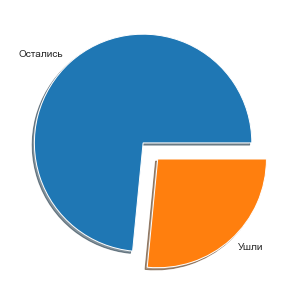

In [81]:
plt.figure(figsize=(5,5))
plt.pie(df['exit'].value_counts(), labels=["Остались", "Ушли"],explode=[0, 0.2], shadow=True)
plt.show()

Стоит заметить,что целевой признак **несбалансирован**.

Визуализируем сначала отношение параметра MonthlyCharges ушедших клиентов к оставшимся.

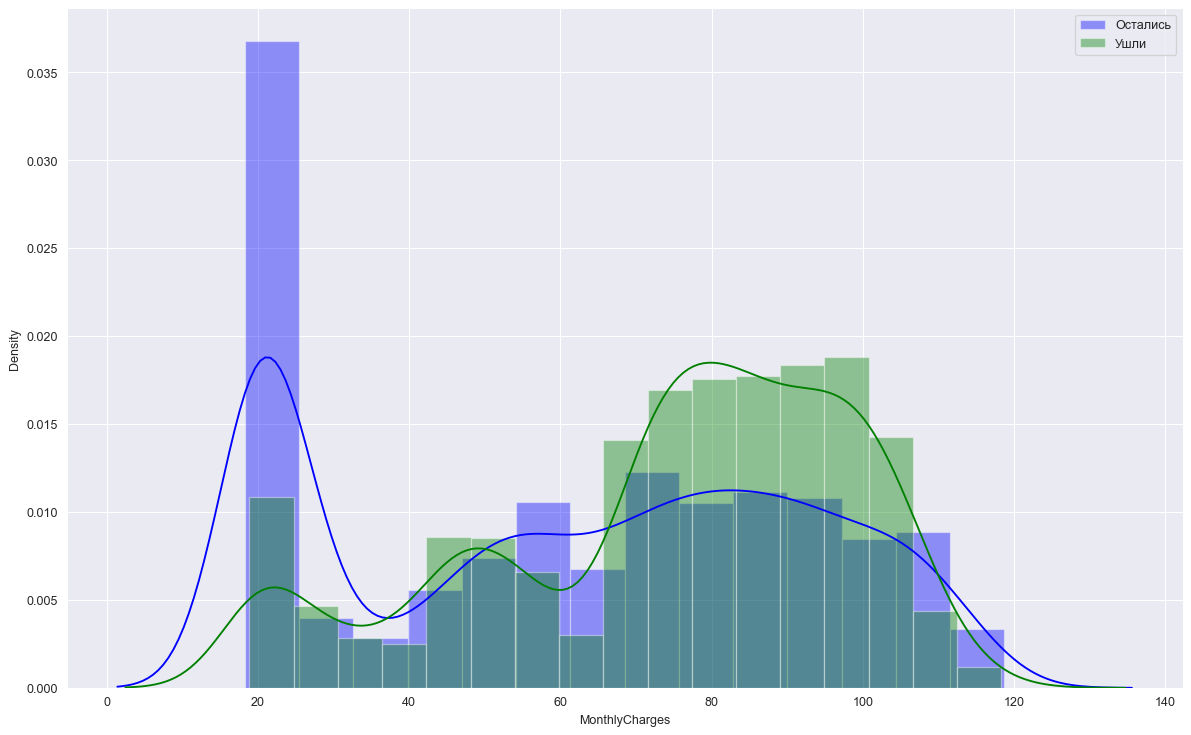

In [82]:
plt.figure(figsize=(16,10), dpi=90)

sns.distplot(clientsStay["MonthlyCharges"], color="blue", label="Остались")
sns.distplot(clientsLeft["MonthlyCharges"], color="green", label="Ушли")

plt.legend()
plt.show()

По графику заметно,что пользователи с дорогими тарифами уходят от оператора чаще остальных.

Для дальнейшего исследования данных имеет смысл добавить признак, который будет показывать какое время ушедшие клиенты пользовались услугами.

In [83]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01' # заменим для оставшихся клиентов, чтобы новый признак был равен 0
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BeforeLeft'] = (df['EndDate'] - df['BeginDate']).dt.days
df = df.drop(columns=['BeginDate', 'EndDate']) # удалим эти столбцы из-за ненадобности

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  internet          7043 non-null   object 
 14  gender            7043 non-null   object 
 15  SeniorCitizen     7043 non-null   object 
 16  Partner           7043 non-null   object 


In [85]:
df.BeforeLeft.sort_values() # отсортированные значения в новом признаке

488        0
3331       0
1340       0
1082       0
3826       0
        ... 
4610    2191
6686    2191
3814    2191
3767    2191
5734    2191
Name: BeforeLeft, Length: 7043, dtype: int64

Рассмотрим уникальные значения в категориальных признаках.

In [87]:
categorial = ['Type', 'InternetService', 'Partner', 'DeviceProtection', 'gender', 'OnlineBackup', 'Dependents',
              'PaperlessBilling', 'StreamingTV','MultipleLines', 'SeniorCitizen', 'TechSupport','OnlineSecurity',
              'StreamingMovies', 'PaymentMethod','phone', 'internet']

In [88]:
for i in categorial:
    print(i)
    print(df[i].unique())


Type
['Month-to-month' 'One year' 'Two year']
InternetService
['DSL' 'Fiber optic' 'No']
Partner
['Yes' 'No']
DeviceProtection
['No' 'Yes']
gender
['Female' 'Male']
OnlineBackup
['Yes' 'No']
Dependents
['No' 'Yes']
PaperlessBilling
['Yes' 'No']
StreamingTV
['No' 'Yes']
MultipleLines
['No' 'Yes']
SeniorCitizen
['No' 'Yes']
TechSupport
['No' 'Yes']
OnlineSecurity
['No' 'Yes']
StreamingMovies
['No' 'Yes']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
phone
['No' 'Yes']
internet
['Yes' 'No']


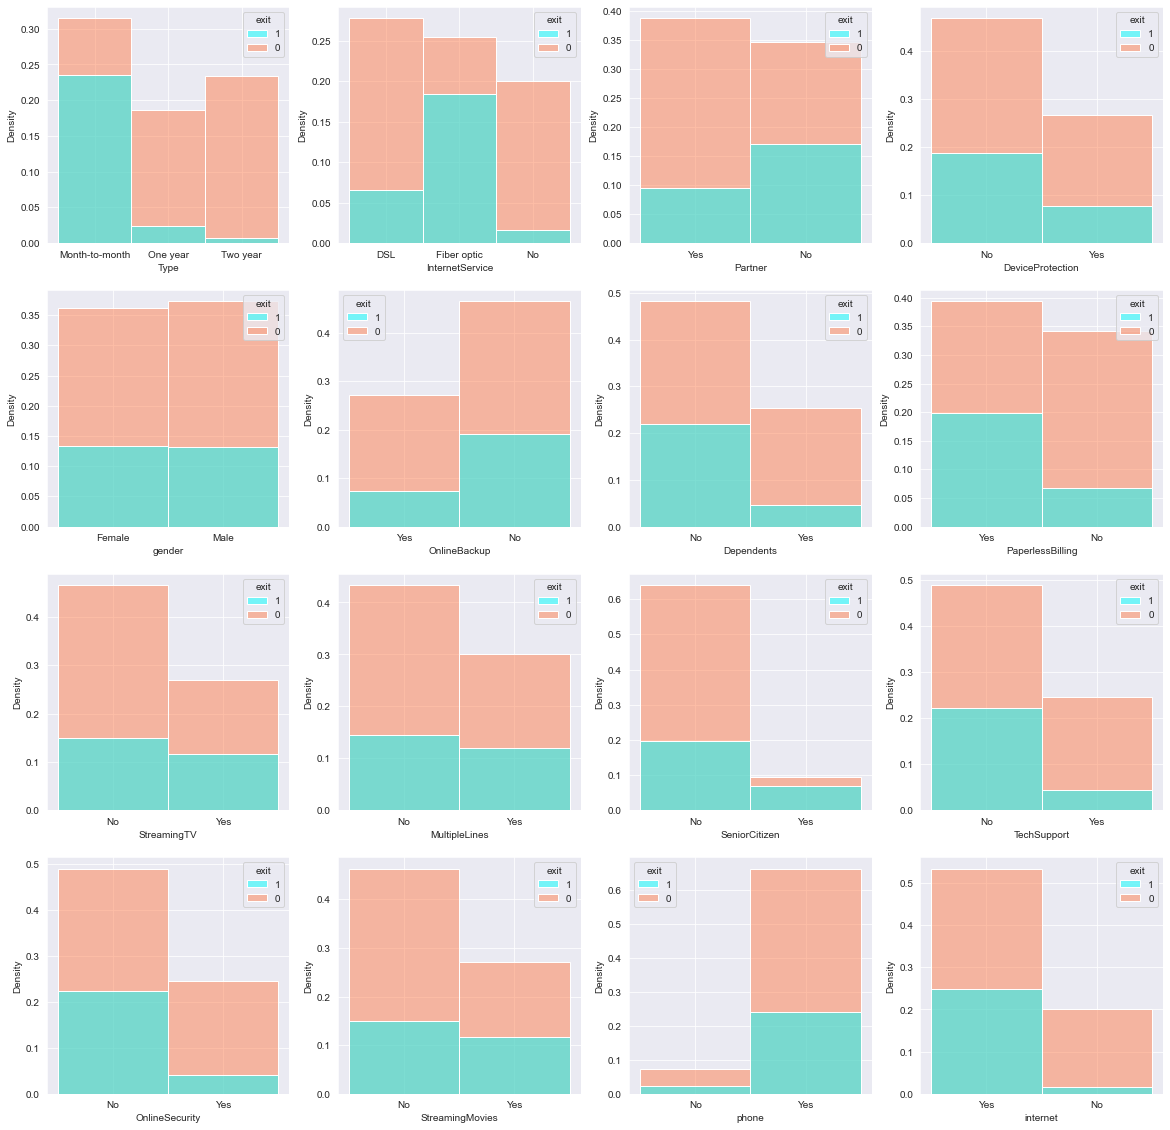

In [89]:
fig, axes =  plt.subplots(4, 4, figsize=(20,20))
h = 0
catHist = categorial.copy()
payMethod = catHist.pop(14)
for i in range(4):
    for j in range(4):
        sns.histplot(ax=axes[i][j], data=df, x=catHist[h],hue="exit", stat="density",palette=["aqua","coral"],hue_order=[1,0])
        if h == 15:
            break
        h+=1


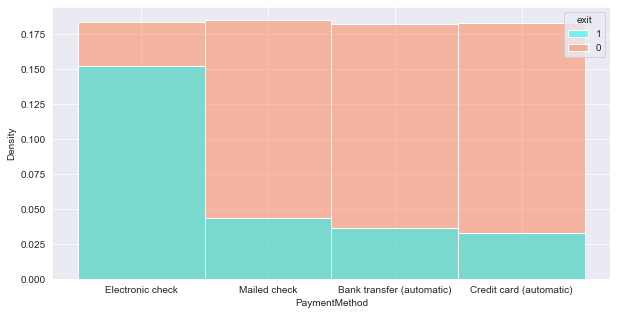

In [64]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x=payMethod,hue="exit", stat="density",palette=["aqua","coral"],hue_order=[1,0])
plt.show()

На гистограммах заметно:
*

## Корреляция

Так как мы можем заметить, что у нас категориальных признаков куда больше, чем количественных, то не имеет смысла использовать коэффициент корреляции **Пиросона**. Более уместным будет использование коэффициента корреляции **Phi_K**. **Phi_K** позволяет
анализировать корреляцию между числовыми, категориальными, интервальными и порядковыми переменными, а также эффективно захватывает нелинейные зависимости.

In [22]:
phikCorrMatrix = df.drop(['customerID'], axis=1).phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'exit', 'BeforeLeft']


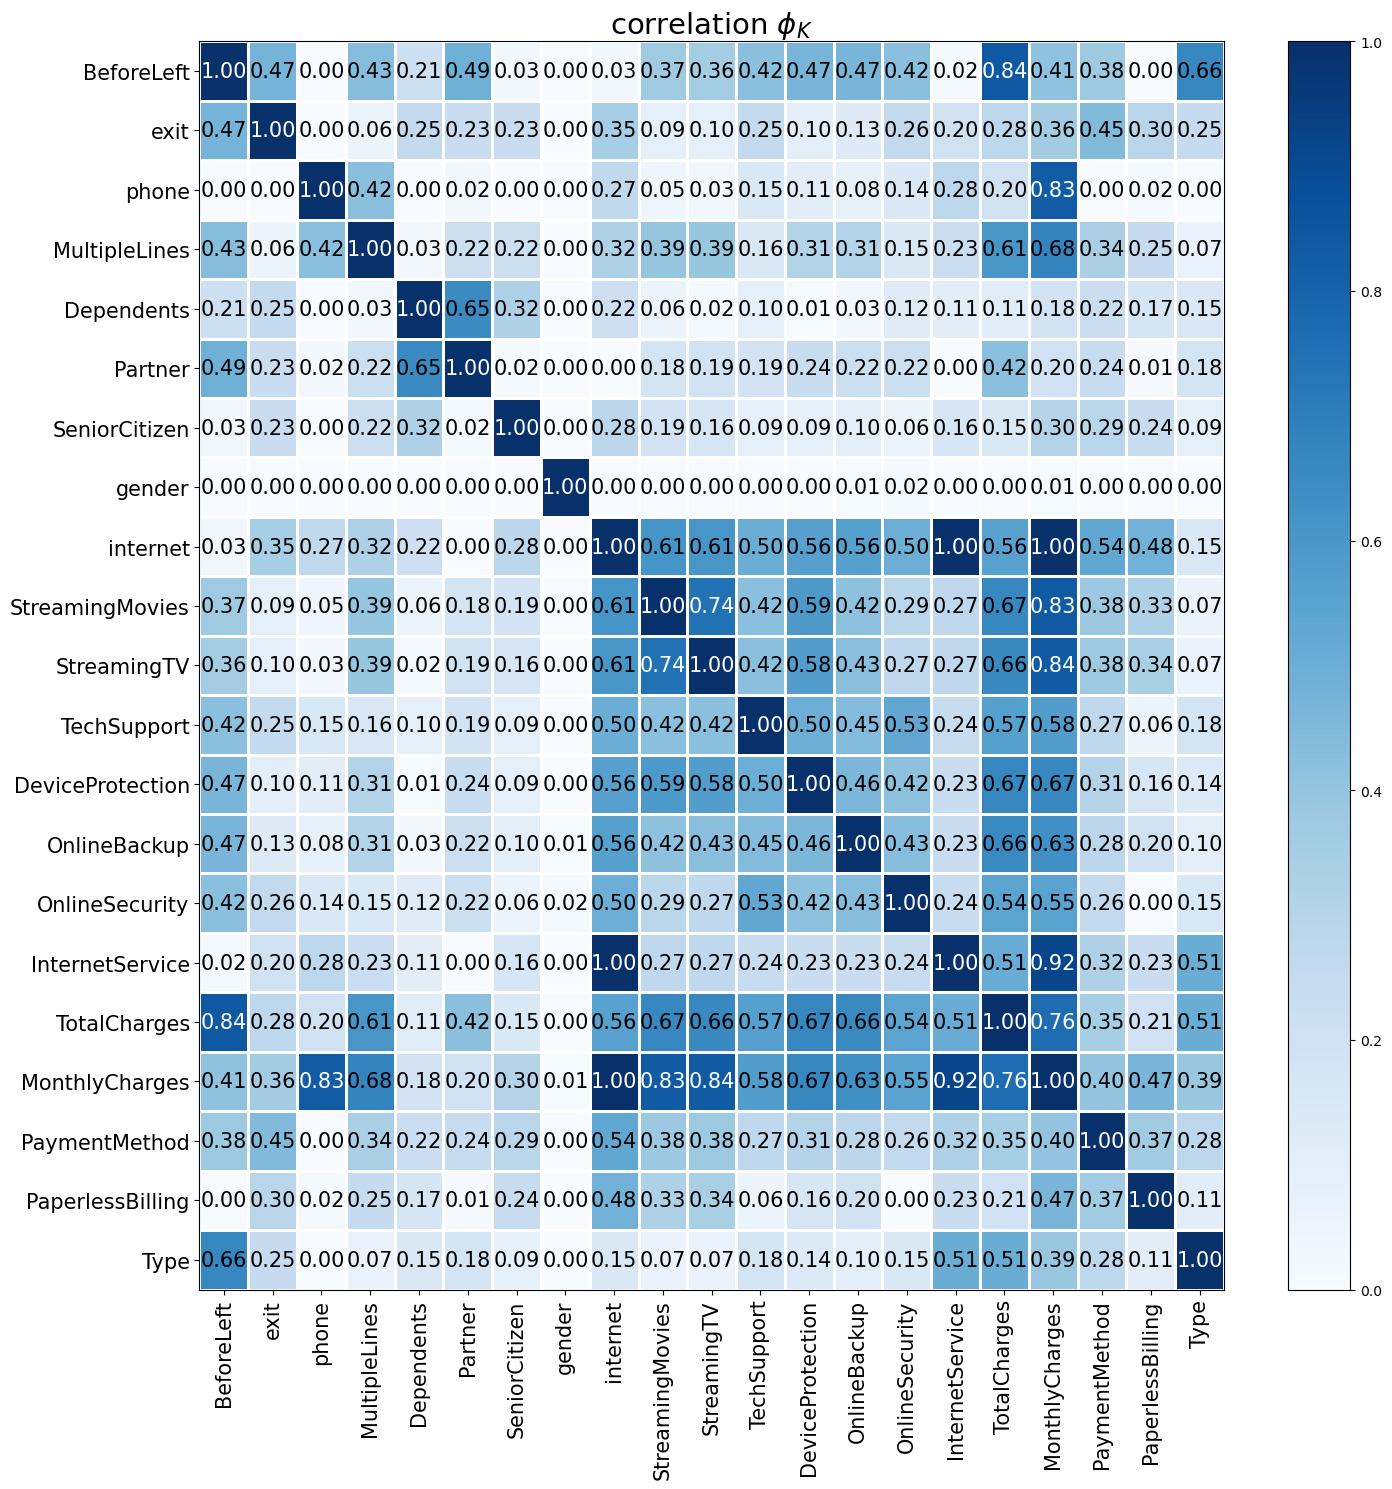

In [23]:
plot_correlation_matrix(phikCorrMatrix.values, x_labels=phikCorrMatrix.columns, y_labels=phikCorrMatrix.index,
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15,15))
plt.tight_layout()

Судя по матрице можем заметить, что добавленный нами ранее признак internet является практически дубликатом признака InternetService, поэтому мы должны удалить internet, т.к. он хоть и лучше коррелирует с целевым признаком, но из-за бинарности даёт не полную картину. Также стоит удалить признак TotalCharges, по той причине, что признака MonthlyCharges достаточно.

In [24]:
df = df.drop(['internet','TotalCharges'],axis=1)
categorial.remove('internet')

Рассмотрим конкретно корреляцию с целевым признаком.

In [25]:
phikCorrMatrix['exit'].sort_values()

phone               0.000000
gender              0.000000
MultipleLines       0.059581
StreamingMovies     0.093923
StreamingTV         0.096865
DeviceProtection    0.101516
OnlineBackup        0.126973
InternetService     0.196202
Partner             0.232930
SeniorCitizen       0.233432
Type                0.251639
Dependents          0.253936
TechSupport         0.254615
OnlineSecurity      0.264580
TotalCharges        0.279152
PaperlessBilling    0.295754
internet            0.349367
MonthlyCharges      0.360050
PaymentMethod       0.449125
BeforeLeft          0.474001
exit                1.000000
Name: exit, dtype: float64

Сильную корреляцию мы можем заметить с признаками BeforeLeft, PaymentMethod, MonthlyCharges. Меньше всего коррелируют пол, наличие телефонии и стриминговые услуги.

In [26]:
df = df.drop(['gender','phone'],axis=1)
categorial.remove('gender')
categorial.remove('phone')

## Разделение выборки

In [27]:
df = df.drop('customerID',axis=1) # в дальнейшем нам вряд ли понадобится этот признак
train, test = train_test_split(
    df, train_size=0.7, random_state=42, stratify=df['exit'])


In [28]:
val, test = train_test_split(
    test, train_size=0.5, random_state=42, stratify=test['exit'])

Убедимся в адекватности разделения нашей выборки, рассмотрев средние значения.

In [29]:
print(train['exit'].mean())
print(test['exit'].mean())
print(val['exit'].mean())

0.2653144016227181
0.26584673604541154
0.26515151515151514


### Кодирование и стандартизирование признаков

In [30]:
X_train, y_train = train.drop('exit',axis=1).copy(), train['exit'].copy()
X_val, y_val = val.drop('exit',axis=1).copy(), val['exit'].copy()
X_test, y_test = test.drop('exit',axis=1).copy(), test['exit'].copy()

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(X_train[categorial])
X_train[
    encoder.get_feature_names_out()
] = encoder.transform(X_train[categorial])

X_train = X_train.drop(categorial, axis=1)
scaler = StandardScaler()
num = X_train.select_dtypes(exclude='object').columns.to_list()

X_train[num] = scaler.fit_transform(X_train[num])
X_train.head()

### RandomForestClassifier

In [ ]:
param_grid = { 
    'n_jobs': [-1],
    'random_state': [42],
    'n_estimators': [200, 500],
    'max_features': ['auto'],
    'max_depth' : [4,6,8],
    'criterion' :['gini','entropy']
}

CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5, n_jobs=-1, scoring='roc_auc')
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_score_

### CatBoostClassifier

In [32]:
train_pool = Pool(data=train.drop('exit',axis=1),label=train['exit'], cat_features=categorial)
test_pool = Pool(data=test.drop('exit',axis=1),label=test['exit'], cat_features=categorial)
val_pool = Pool(data=val.drop('exit',axis=1),label=val['exit'], cat_features=categorial)

model = CatBoostClassifier(iterations=1200,
                           eval_metric="AUC",
                           loss_function="Logloss",
                           task_type="CPU",
                           verbose=False,
                           )

grid = {"learning_rate": [0.1, 0.01],
        "depth": [6, 10],}

model_grid_result = model.grid_search(grid,train_pool,plot=True, verbose=False)



In [41]:
model_grid_result['params']

{'depth': 6, 'learning_rate': 0.1}

In [42]:
max(model_grid_result['cv_results']['test-AUC-mean'])

0.9072044902979107

model = CatBoostClassifier(iterations=1200,
                           eval_metric="AUC",
                           loss_function="Logloss",
                           task_type="CPU",
                           verbose=False,
                           depth=6,
                           learning_rate=0.1
                          )
model.fit(train_pool,
          eval_set=val_pool,
          plot=True,
          silent=True)


In [48]:
m = model.predict_proba(test_pool)[:,1]

In [ ]:
model = CatBoostClassifier.load_model('secondmodel')

In [ ]:
print(m)

In [ ]:
model.save_model('secondmodel')


In [49]:
roc_auc_score(test['exit'],m)

0.9202727739663206